In [1]:
# On utilise %pip pour cibler le bon environnement Python
# On ajoute --user pour éviter l'erreur "Accès refusé"

print("Installation de PyTorch (version CUDA)...")
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu122 --user

print("Installation des outils d'image...")
%pip install opencv-python pillow numpy matplotlib tqdm --user

print("Installation de Transformers et Hugging Face...")
%pip install transformers huggingface-hub peft accelerate --user
%pip install tensorboard

print("Installation terminée. VEUILLEZ REDÉMARRER LE KERNEL.")

Installation de PyTorch (version CUDA)...
Looking in indexes: https://download.pytorch.org/whl/cu122
Note: you may need to restart the kernel to use updated packages.
Installation des outils d'image...


ERROR: Could not find a version that satisfies the requirement torchvision (from versions: none)
ERROR: No matching distribution found for torchvision

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\loicd\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
Installation de Transformers et Hugging Face...



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\loicd\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\loicd\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
Installation terminée. VEUILLEZ REDÉMARRER LE KERNEL.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\loicd\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
from PIL import Image
import io
from pathlib import Path
import os
import torch
import matplotlib.pyplot as plt
import random
from peft import LoraConfig, get_peft_model, TaskType

C:\Users\loicd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
print("Import réussi !")

Import réussi !


Preparation de l'env


In [4]:
def load_pretrained_model(model_name="depth-anything/Depth-Anything-V2-Small-hf"):
    """
    Charge le modèle Depth Anything V2 pré-entraîné et son processeur d'images
    """
    print(f"Chargement du modèle: {model_name}")

    image_processor = AutoImageProcessor.from_pretrained(model_name)
    base_model = AutoModelForDepthEstimation.from_pretrained(model_name)

    print(f"Modèle chargé avec succès")
    return base_model, image_processor

In [5]:
base_model, image_processor = load_pretrained_model()

Chargement du modèle: depth-anything/Depth-Anything-V2-Small-hf


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Modèle chargé avec succès


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
base_model = base_model.to(device)

In [7]:
# Count parameters
total_params = sum(p.numel() for p in base_model.parameters())
trainable_params = sum(p.numel() for p in base_model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Total parameters: 24,785,089
Trainable parameters: 24,785,089


In [8]:
# ===================================================
# INSPECT MODEL ARCHITECTURE
# ===================================================
print("Inspecting model architecture...")
print("\n" + "="*60)

# Print all module names
print("MODEL STRUCTURE:")
for name, module in base_model.named_modules():
    print(f"  {name}: {module.__class__.__name__}")

print("\n" + "="*60)
print("TRAINABLE LAYERS (before LoRA):")
for name, param in base_model.named_parameters():
    if param.requires_grad:
        print(f"  {name}: {param.shape}")

Inspecting model architecture...

MODEL STRUCTURE:
  : DepthAnythingForDepthEstimation
  backbone: Dinov2Backbone
  backbone.embeddings: Dinov2Embeddings
  backbone.embeddings.patch_embeddings: Dinov2PatchEmbeddings
  backbone.embeddings.patch_embeddings.projection: Conv2d
  backbone.embeddings.dropout: Dropout
  backbone.encoder: Dinov2Encoder
  backbone.encoder.layer: ModuleList
  backbone.encoder.layer.0: Dinov2Layer
  backbone.encoder.layer.0.norm1: LayerNorm
  backbone.encoder.layer.0.attention: Dinov2Attention
  backbone.encoder.layer.0.attention.attention: Dinov2SelfAttention
  backbone.encoder.layer.0.attention.attention.query: Linear
  backbone.encoder.layer.0.attention.attention.key: Linear
  backbone.encoder.layer.0.attention.attention.value: Linear
  backbone.encoder.layer.0.attention.output: Dinov2SelfOutput
  backbone.encoder.layer.0.attention.output.dense: Linear
  backbone.encoder.layer.0.attention.output.dropout: Dropout
  backbone.encoder.layer.0.layer_scale1: Dinov2L

PREPARATION  des données

In [9]:

path_images = r"C:\Users\loicd\Desktop\DATASET_DEVOIR\DATASET_DEVOIR\images"
path_depths = r"C:\Users\loicd\Desktop\DATASET_DEVOIR\DATASET_DEVOIR\depth"

In [10]:
print(f"Dossier Images visé : {path_images}")
print(f"Dossier Depth visé  : {path_depths}")

# Vérification que les dossiers existent
if os.path.exists(path_images) and os.path.exists(path_depths):
    print("\nLes dossiers existent !")
    
    # Compter les fichiers pour être sûr
    nb_img = len([f for f in os.listdir(path_images) if f.endswith(('.png', '.jpg'))])
    nb_npy = len([f for f in os.listdir(path_depths) if f.endswith('.npy')])
    
    print(f"   -> Trouvé {nb_img} images")
    print(f"   -> Trouvé {nb_npy} fichiers XYZ (.npy)")
else:
    print("\n❌ ERREUR : Un des chemins est introuvable.")
    print("   Vérifie l'orthographe ou copie le chemin absolu.")

Dossier Images visé : C:\Users\loicd\Desktop\DATASET_DEVOIR\DATASET_DEVOIR\images
Dossier Depth visé  : C:\Users\loicd\Desktop\DATASET_DEVOIR\DATASET_DEVOIR\depth

Les dossiers existent !
   -> Trouvé 58 images
   -> Trouvé 58 fichiers XYZ (.npy)


In [11]:
# 2. COMPTAGE ET LISTING
# ==========================================
print("Démarrage de la vérification...")

# On liste et on trie pour garantir l'ordre
# On ne garde que les fichiers (pas les dossiers cachés)
files_img = sorted([f for f in os.listdir(path_images) if f.endswith(('.png', '.jpg'))])
files_npy = sorted([f for f in os.listdir(path_depths) if f.endswith('.npy')])

num_img = len(files_img)
num_npy = len(files_npy)

print(f"Bilan comptable :")
print(f"   - Images (.png/.jpg) : {num_img}")
print(f"   - Depths (.npy)      : {num_npy}")

Démarrage de la vérification...
Bilan comptable :
   - Images (.png/.jpg) : 58
   - Depths (.npy)      : 58


In [12]:
# Analyse des données image par image
import numpy as np
import os

print(f"Analyse de {len(files_npy)} fichiers .npy pixel par pixel...")

# Initialisation des compteurs globaux
total_nan_global = 0
total_zero_global = 0
total_inf_global = 0
total_pixels_analyses = 0

rapport_erreurs = {}

for filename in files_npy:
    full_path = os.path.join(path_depths, filename)
    
    try:
        data = np.load(full_path)
        total_pixels_analyses += data.size
        
        # Détection par type
        num_nan = np.count_nonzero(np.isnan(data))
        num_zero = np.count_nonzero(data == 0)
        num_inf = np.count_nonzero(np.isinf(data))
        
        # Somme des manquants pour ce fichier précis
        total_manquants_file = num_nan + num_zero + num_inf

        # Mise à jour des compteurs globaux
        total_nan_global += num_nan
        total_zero_global += num_zero
        total_inf_global += num_inf

        if total_manquants_file > 0:
            # On stocke les détails pour le rapport final
            rapport_erreurs[filename] = {
                "nan": num_nan, 
                "zero": num_zero, 
                "inf": num_inf, 
                "total": total_manquants_file,
                "shape": data.shape
            }
            # Affichage immédiat pour suivre l'avancement
            print(f"{filename} : {total_manquants_file} valeurs manquantes détectées")

    except Exception as e:
        print(f"Erreur lecture {filename}: {e}")

# --- Résumé final détaillé ---
print("\n" + "="*50)
print("BILAN DÉTAILLÉ PAR IMAGE")
print("="*50)

if not rapport_erreurs:
    print("✨ Félicitations ! Aucun pixel manquant sur l'ensemble du dataset.")
else:
    # On trie les erreurs pour afficher les fichiers les plus problématiques en premier
    fichiers_tries = sorted(rapport_erreurs.items(), key=lambda x: x[1]['total'], reverse=True)
    
    for filename, stats in fichiers_tries:
        print(f"{filename :<25} | Total manquants: {stats['total']:<8} (NaN:{stats['nan']}, 0:{stats['zero']})")

    print("\n" + "="*50)
    print("STATISTIQUES GLOBALES")
    print("-" * 50)
    total_anomalies = total_nan_global + total_zero_global + total_inf_global
    print(f"Total pixels analysés : {total_pixels_analyses:,}")
    print(f"Total valeurs manquantes : {total_anomalies:,}")
    
    if total_pixels_analyses > 0:
        pourcentage = (total_anomalies / total_pixels_analyses) * 100
        print(f"Taux de corruption global : {pourcentage:.4f}%")
    print(f"Nombre de fichiers affectés : {len(rapport_erreurs)} / {len(files_npy)}")

Analyse de 58 fichiers .npy pixel par pixel...
21-12-03-18-50-31_Zivid_acquisition_rawDepth.npy : 2116980 valeurs manquantes détectées
21-12-03-18-50-34_Zivid_acquisition_rawDepth.npy : 1730646 valeurs manquantes détectées
21-12-03-18-50-37_Zivid_acquisition_rawDepth.npy : 1655943 valeurs manquantes détectées
21-12-03-18-50-39_Zivid_acquisition_rawDepth.npy : 2033433 valeurs manquantes détectées
21-12-03-18-50-55_Zivid_acquisition_rawDepth.npy : 2366760 valeurs manquantes détectées
21-12-03-18-52-27_Zivid_acquisition_rawDepth.npy : 1982451 valeurs manquantes détectées
21-12-03-18-52-30_Zivid_acquisition_rawDepth.npy : 1700013 valeurs manquantes détectées
21-12-03-18-52-32_Zivid_acquisition_rawDepth.npy : 2108175 valeurs manquantes détectées
21-12-03-18-52-35_Zivid_acquisition_rawDepth.npy : 1727091 valeurs manquantes détectées
21-12-03-18-52-37_Zivid_acquisition_rawDepth.npy : 1658802 valeurs manquantes détectées
21-12-03-18-52-40_Zivid_acquisition_rawDepth.npy : 2079984 valeurs manqua

### Gestion des valeurs manquantes
#### L'Inpainting (Rebouchage par voisinage)
C'est la méthode la plus utilisée en vision par ordinateur. Elle consiste à "remplir" les zones vides en interpolant les couleurs ou les valeurs à partir des pixels sains situés sur les bords de la zone manquante.

#### L'Interpolation Spatiale (Plus proche voisin)
Pour des données purement numériques comme la profondeur, on peut utiliser des méthodes mathématiques pour estimer la valeur d'un pixel en fonction de ses voisins valides.

### La méthode que nous avons choisie pour préserver l’efficacité consiste à remplacer les valeurs manquantes par 0.

In [13]:
# ==========================================
# 3. VÉRIFICATION DE L'ALIGNEMENT
# ==========================================
if num_img != num_npy:
    print(f"ATTENTION : Le nombre de fichiers ne correspond pas ! (Différence : {abs(num_img - num_npy)})")
else:
    print("Le nombre de fichiers est identique.")

# Vérification des correspondances de noms (optionnel mais recommandé)
# On vérifie si image_01_color.png a bien son équivalent image_01_rawDepth.npy
mismatches = []
for img_name in files_img:
    # On recrée le nom attendu du fichier depth (selon la logique Zivid vue dans ton notebook)
    # Ex: "scan_color.png" -> "scan_rawDepth.npy"
    expected_depth_name = img_name.replace("_color.png", "_rawDepth.npy").replace(".png", ".npy")
    
    # Si tes fichiers n'ont pas "_color", ajuste cette ligne (ex: replace(".png", ".npy"))
    
    if expected_depth_name not in files_npy:
        mismatches.append((img_name, expected_depth_name))

if len(mismatches) > 0:
    print(f"ATTENTION : {len(mismatches)} paires ne correspondent pas au niveau du nom !")
    print(f"   Exemple de manquant : {mismatches[0]}")
else:
    print("Tous les noms de fichiers semblent correspondre (logique color <-> rawDepth).")

Le nombre de fichiers est identique.
Tous les noms de fichiers semblent correspondre (logique color <-> rawDepth).


In [14]:
# ==========================================
# 4. TEST D'EXTRACTION DU Z (Le fameux Z)
# ==========================================

if num_npy > 0:
    print("\nTest d'extraction du canal Z sur un fichier aléatoire...")
    
    # Prendre un fichier au hasard
    random_npy = random.choice(files_npy)
    full_path = os.path.join(path_depths, random_npy)
    
    try:
        # Chargement
        data = np.load(full_path) # Shape (H, W, 3) normalement
        
        print(f"   Fichier : {random_npy}")
        print(f"   Shape originale : {data.shape}")
        
        if len(data.shape) == 3 and data.shape[2] == 3:
            # EXTRACTION DU Z (Canal index 2)
            Z_channel = data[:, :, 2]
            
            # Vérif statistiques
            print(f"   Extraction Z réussie ! Shape finale : {Z_channel.shape}")
            print(f"   Val Min (avec NaN) : {np.nanmin(Z_channel)}")
            print(f"   Val Max (avec NaN) : {np.nanmax(Z_channel)}")
            
            # Vérification des NaN
            nan_count = np.isnan(Z_channel).sum()
            print(f"   Nombre de pixels NaN (vides) : {nan_count} ({(nan_count/Z_channel.size)*100:.1f}%)")
        else:
            print("Erreur : Le fichier .npy n'a pas 3 canaux (XYZ). Vérifie le format.")
            
    except Exception as e:
        print(f"Erreur lors du chargement : {e}")


Test d'extraction du canal Z sur un fichier aléatoire...
   Fichier : 22-11-10-15-39-33_Zivid_acquisition_rawDepth.npy
   Shape originale : (1200, 1944, 3)
   Extraction Z réussie ! Shape finale : (1200, 1944)
   Val Min (avec NaN) : 284.2788391113281
   Val Max (avec NaN) : 2065.427734375
   Nombre de pixels NaN (vides) : 824108 (35.3%)


In [15]:
filename = "21-12-03-19-05-46_Zivid_acquisition_rawDepth.npy"
full_path = os.path.join(path_depths, filename)

# --- EXTRACTION ---
# 1. Chargement de la donnée (1200, 1944, 3)
data_xyz = np.load(full_path)

# 2. Extraction de la carte de profondeur Z (1200, 1944)
Z_channel = data_xyz[:, :, 2] 

# 3. Traitement des NaN (pour s'assurer qu'on peut lire)
Z_clean = np.nan_to_num(Z_channel, nan=0.0)

# --- LECTURE DE LA VALEUR D'UN PIXEL ---
pixel_row = 600
pixel_col = 972

# Accéder à la valeur Z du pixel (600, 972)
profondeur_pixel = Z_clean[pixel_row, pixel_col]

print(f"Le fichier chargé est de forme : {Z_channel.shape}")
print(f"La valeur de Profondeur (Z) au pixel [{pixel_row}, {pixel_col}] est :")
print(f"-> **{profondeur_pixel:.2f} mm**")

Le fichier chargé est de forme : (1200, 1944)
La valeur de Profondeur (Z) au pixel [600, 972] est :
-> **1365.02 mm**


Nous avons choisi de traiter les données (extraire le canal Z et remplacer les NaN par 0.0) dans la fonction __getitem__ de la classe Dataset (c'est-à-dire pendant l'entraînement) au lieu de le faire une seule fois en amont.1. Efficacité et Économie de Stockage (Le Plus Important) Votre jeu de données est lourd, et l'objectif est d'éviter de créer des doublons :Données Brutes : Chaque fichier .npy stocke 3 canaux (X, Y, Z).Données Cible : Nous n'avons besoin que d'1 canal (Z).Si nous avions extrait Z et créé un nouveau fichier .npy pour chaque image :Vous auriez doublé le nombre de fichiers sur votre disque dur (un dossier images, un dossier depth_xyz, et un nouveau dossier depth_z_seul).Bien que le fichier de profondeur Z soit plus petit que le fichier XYZ, vous auriez passé un temps considérable à générer et stocker des milliers de nouveaux fichiers.En faisant l'opération à la volée, le processus est : Lire le fichier original (XYZ) $\rightarrow$ Extraire Z en mémoire RAM $\rightarrow$ Transférer vers le GPU. Aucune duplication n'est nécessaire sur le disque.

Configuration de LoRA


In [16]:

# --- 3. DÉFINITION DE LA CONFIGURATION LoRA ---

# Pour les Vision Transformers, nous ciblons les couches d'attention (Query, Key, Value)
lora_config = LoraConfig(
    r=16,                                    # Le rang de la matrice LoRA (ajustement de la capacité d'apprentissage)
    lora_alpha=32,                           # Facteur de mise à l'échelle (généralement 2 * r)
    target_modules=["query", "key", "value"],# Les couches spécifiques du ViT à modifier (Attention)
    lora_dropout=0.05,                       # Dropout appliqué aux couches LoRA
    bias="none",                             # Ne pas adapter les biais
)

In [17]:
# La fonction get_peft_model gèle les poids du modèle de base et ajoute les adaptateurs LoRA
model_lora = get_peft_model(base_model, lora_config)

print("✅ Modèle LoRA appliqué !")
# Afficher le nombre de paramètres entraînés
model_lora.print_trainable_parameters()

✅ Modèle LoRA appliqué !
trainable params: 442,368 || all params: 25,227,457 || trainable%: 1.7535


In [18]:
def depth_data_collator(features):
    return {
        "pixel_values": torch.stack([x["pixel_values"] for x in features]),
        "labels": torch.stack([x["depth_gt"] for x in features]),
        "valid_mask": torch.stack([x["valid_mask"] for x in features]),
    }

In [19]:
# ===================================================
# CALCUL DES STATISTIQUES GLOBALES DU DATASET
# ===================================================
print("Calcul des statistiques sur TOUS les fichiers depth...")
print("   (Cela peut prendre quelques minutes...)\n")

depth_stats = {
    'min_values': [],
    'max_values': [],
    'mean_values': [],
    'valid_percentages': []
}

# Parcourir TOUS les fichiers .npy
from tqdm import tqdm  # Pour une barre de progression

for depth_file in tqdm(files_npy, desc="Analyse des fichiers depth"):
    depth_path = os.path.join(path_depths, depth_file)
    
    # Charger et extraire Z
    depth_xyz = np.load(depth_path)
    depth_z = depth_xyz[:, :, 2]
    
    # Calculer statistiques (en ignorant NaN)
    if not np.all(np.isnan(depth_z)):  # Si au moins une valeur valide
        depth_stats['min_values'].append(np.nanmin(depth_z))
        depth_stats['max_values'].append(np.nanmax(depth_z))
        depth_stats['mean_values'].append(np.nanmean(depth_z))
        
        # % de pixels valides
        valid_pct = (~np.isnan(depth_z)).sum() / depth_z.size * 100
        depth_stats['valid_percentages'].append(valid_pct)

# Calculer les statistiques globales
GLOBAL_MIN = np.min(depth_stats['min_values'])
GLOBAL_MAX = np.max(depth_stats['max_values'])
GLOBAL_MEAN = np.mean(depth_stats['mean_values'])
GLOBAL_STD = np.std(depth_stats['mean_values'])

print("\n" + "="*60)
print("STATISTIQUES GLOBALES DU DATASET")
print("="*60)
print(f"Profondeur MIN (sur tous les fichiers): {GLOBAL_MIN:.2f} mm")
print(f"Profondeur MAX (sur tous les fichiers): {GLOBAL_MAX:.2f} mm")
print(f"Moyenne des moyennes: {GLOBAL_MEAN:.2f} mm")
print(f"Écart-type: {GLOBAL_STD:.2f} mm")
print(f"Pixels valides (moyenne): {np.mean(depth_stats['valid_percentages']):.1f}%")
print("="*60)

# Ces valeurs vont servir pour la normalisation!
print(f"\nUtilisez ces valeurs dans votre Dataset:")
print(f"   depth_min = {GLOBAL_MIN:.2f}")
print(f"   depth_max = {GLOBAL_MAX:.2f}")

Calcul des statistiques sur TOUS les fichiers depth...
   (Cela peut prendre quelques minutes...)



Analyse des fichiers depth: 100%|██████████| 58/58 [00:01<00:00, 33.85it/s]


STATISTIQUES GLOBALES DU DATASET
Profondeur MIN (sur tous les fichiers): 251.74 mm
Profondeur MAX (sur tous les fichiers): 3907.45 mm
Moyenne des moyennes: 1542.16 mm
Écart-type: 295.35 mm
Pixels valides (moyenne): 68.5%

Utilisez ces valeurs dans votre Dataset:
   depth_min = 251.74
   depth_max = 3907.45


In [20]:
# ===================================================
# DATASET AVEC NORMALISATION CORRECTE
# ===================================================
from torch.utils.data import Dataset, DataLoader
class ZividDepthDataset(Dataset):
    """
    Dataset pour charger les paires RGB-Depth Zivid
    """
    def __init__(self, image_folder, depth_folder, image_files, depth_files, 
                 processor, depth_min, depth_max):
        """
        Args:
            image_folder: Chemin vers dossier images
            depth_folder: Chemin vers dossier depth
            image_files: Liste des noms de fichiers images
            depth_files: Liste des noms de fichiers depth
            processor: ImageProcessor de Hugging Face
            depth_min: Valeur minimale de profondeur (en mm)
            depth_max: Valeur maximale de profondeur (en mm)
        """
        self.image_folder = image_folder
        self.depth_folder = depth_folder
        self.image_files = image_files
        self.depth_files = depth_files
        self.processor = processor
        self.depth_min = depth_min
        self.depth_max = depth_max
        
        print(f"Dataset créé:")
        print(f"   Échantillons: {len(self.image_files)}")
        print(f"   Normalisation: [{depth_min:.2f}, {depth_max:.2f}] mm → [0, 1]")
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # 1. Charger l'image RGB
        img_path = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        
        # 2. Charger le fichier depth XYZ
        depth_path = os.path.join(self.depth_folder, self.depth_files[idx])
        depth_xyz = np.load(depth_path)
        
        # 3. Extraire le canal Z (profondeur)
        depth_z = depth_xyz[:, :, 2]  # Shape: (1200, 1944)
        
        # 4. Créer un masque des pixels valides (pour la loss)
        valid_mask = ~np.isnan(depth_z)
        
        # 5. Remplacer NaN par 0 temporairement
        depth_z_clean = np.nan_to_num(depth_z, nan=0.0)
        
        # 6. Normaliser la profondeur entre 0 et 1
        depth_normalized = (depth_z_clean - self.depth_min) / (self.depth_max - self.depth_min)
        depth_normalized = np.clip(depth_normalized, 0, 1)
        
        # 7. Preprocessing de l'image
        inputs = self.processor(images=image, return_tensors="pt")
        
        # 8. Retourner tout
        return {
            'pixel_values': inputs['pixel_values'].squeeze(0),
            'depth_gt': torch.from_numpy(depth_normalized).float(),
            'valid_mask': torch.from_numpy(valid_mask).float(),
            'filename': self.image_files[idx]
        }

print("Classe Dataset (v2) définie avec normalisation!")

Classe Dataset (v2) définie avec normalisation!


In [21]:
# ===================================================
# SPLIT TRAIN / VALIDATION
# ===================================================
from sklearn.model_selection import train_test_split

# Vos fichiers déjà triés
files_img = sorted([f for f in os.listdir(path_images) if f.endswith('.png')])
files_npy = sorted([f for f in os.listdir(path_depths) if f.endswith('.npy')])

print(f"Total de fichiers: {len(files_img)}")

# Split 80% train, 20% validation
train_imgs, val_imgs, train_depths, val_depths = train_test_split(
    files_img, files_npy, 
    test_size=0.2,  # 20% validation
    random_state=42,  # Pour reproductibilité
    shuffle=True
)

print(f"Split effectué:")
print(f"   Train: {len(train_imgs)} échantillons")
print(f"   Val:   {len(val_imgs)} échantillons")

Total de fichiers: 58
Split effectué:
   Train: 46 échantillons
   Val:   12 échantillons


In [22]:
# ===================================================
# CRÉATION DES DATALOADERS
# ===================================================

# Créer les datasets
train_dataset = ZividDepthDataset(
    image_folder=path_images,
    depth_folder=path_depths,
    image_files=train_imgs,
    depth_files=train_depths,
    processor=image_processor,
    depth_min = 251.74,
   depth_max = 3907.45
)

val_dataset = ZividDepthDataset(
    image_folder=path_images,
    depth_folder=path_depths,
    image_files=val_imgs,
    depth_files=val_depths,
    processor=image_processor,
    depth_min = 251.74,
   depth_max = 3907.45
)

# Créer les dataloaders
BATCH_SIZE = 2  # Petit batch car images volumineuses

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,  # Mélanger pour l'entraînement
    num_workers=0,  # 0 pour Windows, 2-4 sinon
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # Pas de mélange pour validation
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

print("DataLoaders créés!")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")

Dataset créé:
   Échantillons: 46
   Normalisation: [251.74, 3907.45] mm → [0, 1]
Dataset créé:
   Échantillons: 12
   Normalisation: [251.74, 3907.45] mm → [0, 1]
DataLoaders créés!
   Train batches: 23
   Val batches: 6


In [23]:
# ===================================================
# TEST DU DATALOADER
# ===================================================
print("\nTest du DataLoader...")

# Récupérer un batch
batch = next(iter(train_loader))

print(f"   Batch chargé avec succès!")
print(f"   pixel_values shape: {batch['pixel_values'].shape}")
print(f"   depth_gt shape: {batch['depth_gt'].shape}")
print(f"   valid_mask shape: {batch['valid_mask'].shape}")
print(f"   Fichiers: {batch['filename']}")

# Vérifier les valeurs
print(f"\n Statistiques:")
print(f"   Depth GT min: {batch['depth_gt'].min():.3f}")
print(f"   Depth GT max: {batch['depth_gt'].max():.3f}")
print(f"   Pixels valides: {batch['valid_mask'].sum().item()} / {batch['valid_mask'].numel()}")


Test du DataLoader...
   Batch chargé avec succès!
   pixel_values shape: torch.Size([2, 3, 518, 840])
   depth_gt shape: torch.Size([2, 1200, 1944])
   valid_mask shape: torch.Size([2, 1200, 1944])
   Fichiers: ['22-10-06-15-18-27_Zivid_acquisition_color.png', '21-12-03-18-57-05_Zivid_acquisition_color.png']

 Statistiques:
   Depth GT min: 0.000
   Depth GT max: 0.589
   Pixels valides: 3436040.0 / 4665600


In [24]:
# ==========================================
# 3. DÉFINITION DES ARGUMENTS ET DU TRAINER
# ==========================================
from transformers import IntervalStrategy,TrainingArguments, Trainer
print("\n3. Initialisation du Trainer...")
OUTPUT_DIR = "./depth_anything_finetuned_lora_zivid" 
BATCH_SIZE = 4 # IMPORTANT: Réduire cette valeur (2 ou 1) si votre GPU manque de VRAM

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    learning_rate=5e-5,               
    num_train_epochs=10,               
    per_device_train_batch_size=BATCH_SIZE,      
    per_device_eval_batch_size=BATCH_SIZE,              
    eval_steps=500,                                  
    save_steps=500,     
    # Reste inchangé :
    logging_steps=50,     
    report_to="tensorboard",          
    save_total_limit=3,               
    fp16=True,                        
    remove_unused_columns=False,        
)


3. Initialisation du Trainer...


In [25]:
#chatgpt
from transformers import Trainer
import torch.nn.functional as F

class DepthTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        """
        Calcule la loss pour l'estimation de profondeur avec masque de pixels valides
        """
        # 1. Récupérer les entrées
        pixel_values = inputs.get("pixel_values")
        labels = inputs.get("labels")        # depth_gt normalisée
        valid_mask = inputs.get("valid_mask", None)

        # 2. Forward du modèle
        outputs = model(pixel_values=pixel_values)
        predicted_depth = outputs.predicted_depth   # [B, H, W] ou [B,1,H,W]

        # 3. Adapter les formes si besoin
        if predicted_depth.dim() == 4:  # [B,1,H,W] → [B,H,W]
            predicted_depth = predicted_depth.squeeze(1)

        if labels.shape != predicted_depth.shape:
            labels = F.interpolate(
                labels.unsqueeze(1) if labels.dim() == 3 else labels,
                size=predicted_depth.shape[-2:],
                mode='bilinear',
                align_corners=False
            ).squeeze(1)

        if valid_mask is None:
            valid_mask = torch.ones_like(labels)
        else:
            if valid_mask.shape != predicted_depth.shape:
                valid_mask = F.interpolate(
                    valid_mask.unsqueeze(1) if valid_mask.dim() == 3 else valid_mask,
                    size=predicted_depth.shape[-2:],
                    mode='nearest'
                ).squeeze(1)

        # 4. MSE masquée
        diff = (predicted_depth - labels) ** 2
        masked_diff = diff * valid_mask
        loss = masked_diff.sum() / (valid_mask.sum() + 1e-8)

        return (loss, outputs) if return_outputs else loss


In [26]:
trainer = DepthTrainer(
    model=model_lora,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=depth_data_collator,
)

print(" Trainer initialisé!")


 Trainer initialisé!


In [27]:
print("\nDémarrage de l'entraînement...\n")
trainer.train()



Démarrage de l'entraînement...



C:\Users\loicd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
50,1.202800
100,0.043400


TrainOutput(global_step=120, training_loss=0.5236015533407529, metrics={'train_runtime': 1045.6988, 'train_samples_per_second': 0.44, 'train_steps_per_second': 0.115, 'total_flos': 9.08893206238752e+16, 'train_loss': 0.5236015533407529, 'epoch': 10.0})

In [28]:
%load_ext tensorboard
%tensorboard --logdir runs


Reusing TensorBoard on port 6006 (pid 12588), started 0:27:19 ago. (Use '!kill 12588' to kill it.)

In [29]:
%tensorboard --logdir ./depth_anything_finetuned_lora_zivid


Reusing TensorBoard on port 6007 (pid 22200), started 0:27:16 ago. (Use '!kill 22200' to kill it.)

In [30]:
%pip install pandas
import pandas as pd
import matplotlib.pyplot as plt

# Convertir les logs en DataFrame
logs = pd.DataFrame(trainer.state.log_history)

# Afficher pour voir les colonnes dispo
display(logs.head())


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\loicd\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


,loss,grad_norm,learning_rate,epoch,step,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,1.2028,0.530758,0.000030,4.166667,50,NaN,NaN,NaN,NaN,NaN
1,0.0434,0.595917,0.000009,8.333333,100,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,10.000000,120,1045.6988,0.44,0.115,9.088932e+16,0.523602


In [31]:
if "eval_loss" in logs.columns:
    eval_logs = logs[logs["eval_loss"].notna()]
    plt.figure(figsize=(7,4))
    plt.plot(eval_logs["step"], eval_logs["eval_loss"])
    plt.xlabel("Step")
    plt.ylabel("Eval loss")
    plt.title("Courbe de loss - validation")
    plt.grid(True)
    plt.show()


In [39]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import random

# Le même min / max que tu as utilisé pour normaliser dans ton Dataset !
DEPTH_MIN = 251.74
DEPTH_MAX = 3907.45

device = next(model_lora.parameters()).device
model_lora.eval()

def denorm_depth(depth_norm):
    """[H, W] en [0,1] → [H, W] en mm"""
    return depth_norm * (DEPTH_MAX - DEPTH_MIN) + DEPTH_MIN

def show_sample(idx):
    sample = val_dataset[idx]

    # 1) Entrées
    pixel_values = sample["pixel_values"].unsqueeze(0).to(device)   # [1,3,H,W]
    depth_gt = sample["depth_gt"].squeeze().numpy()                 # [H,W] normalisée [0,1]

    # 2) Prédiction
    with torch.no_grad():
        outputs = model_lora(pixel_values=pixel_values)
        pred = outputs.predicted_depth  # [1,1,H,W] ou [1,H,W]

    pred = pred.squeeze().cpu().numpy()   # [H,W] normalisée [0,1]

    # 3) Dénormalisation en mm
    depth_gt_mm = denorm_depth(depth_gt)
    pred_mm = denorm_depth(pred)

    # 4) Récupérer l'image RGB d'origine si tu l'as gardée
    # Si ton dataset ne garde pas l'image brute, tu peux au moins afficher pixel_values
    img = pixel_values[0].cpu().numpy()   # [3,H,W]
    img = np.transpose(img, (1, 2, 0))    # [H,W,3]

    # 5) Affichage
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(np.clip(img, 0, 1))
    axes[0].set_title(f"Image RGB (idx={idx})")
    axes[0].axis("off")

    vmin, vmax = DEPTH_MIN, DEPTH_MAX

    im1 = axes[1].imshow(depth_gt_mm, cmap="inferno", vmin=vmin, vmax=vmax)
    axes[1].set_title("Profondeur GT (mm)")
    axes[1].axis("off")
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    im2 = axes[2].imshow(pred_mm, cmap="inferno", vmin=vmin, vmax=vmax)
    axes[2].set_title("Profondeur prédite (mm)")
    axes[2].axis("off")
    plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()


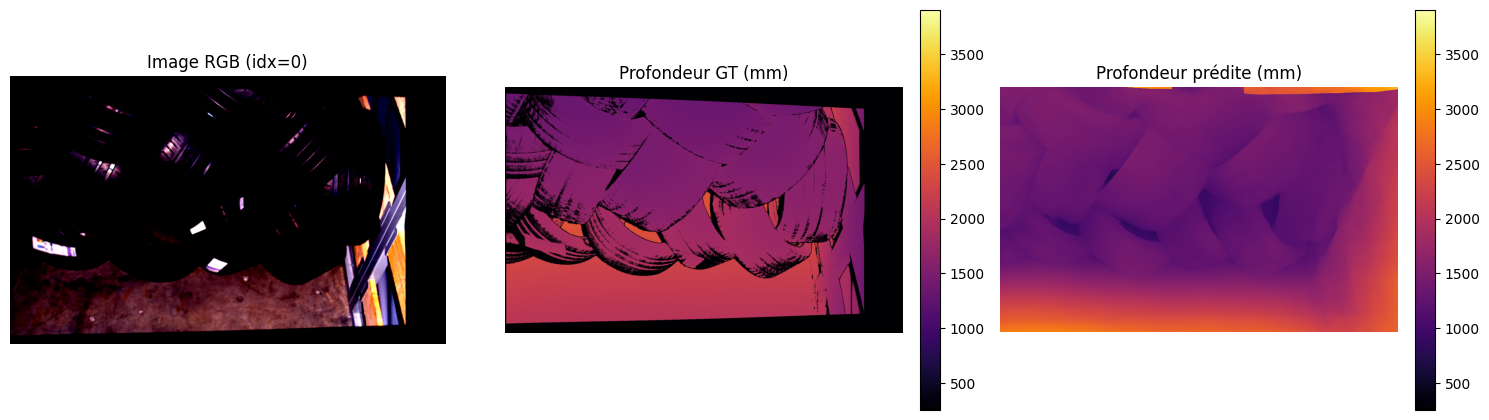

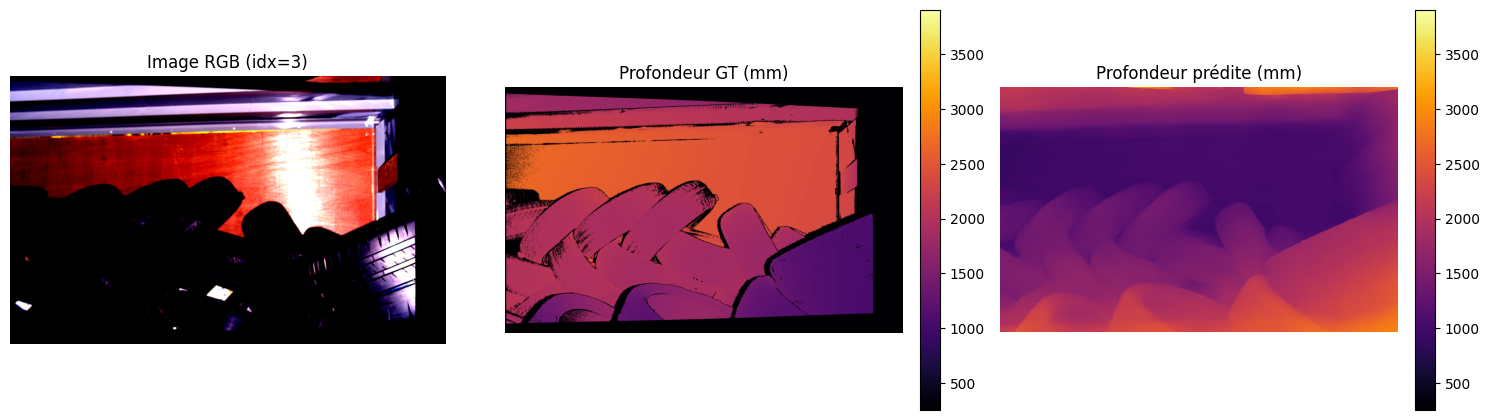

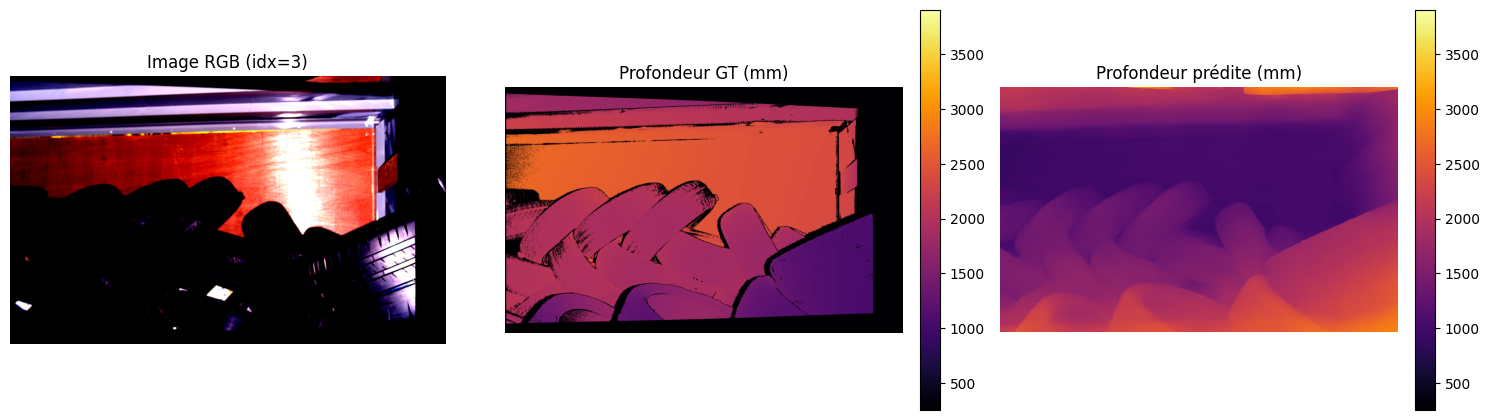

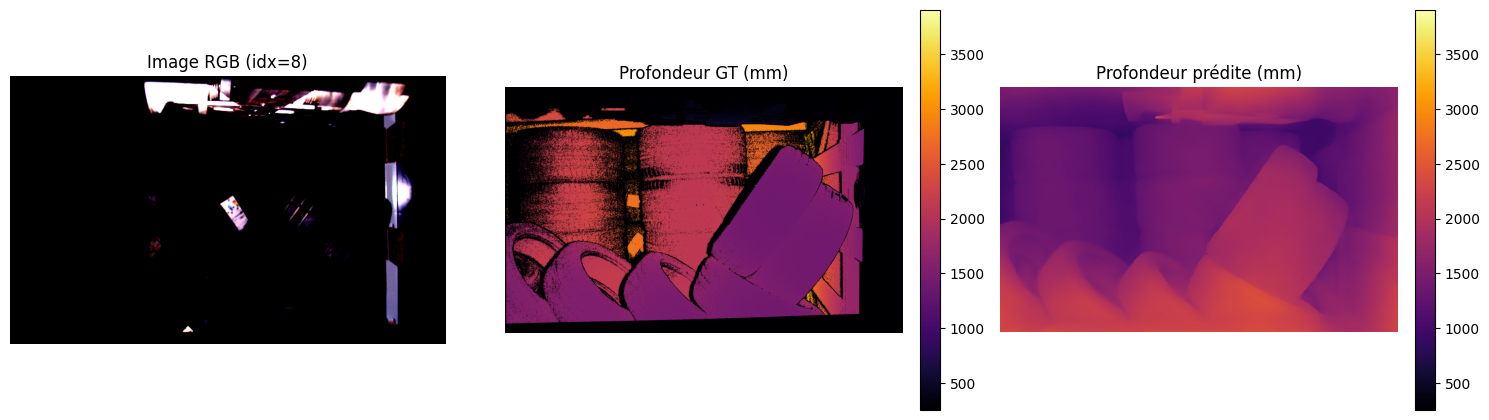

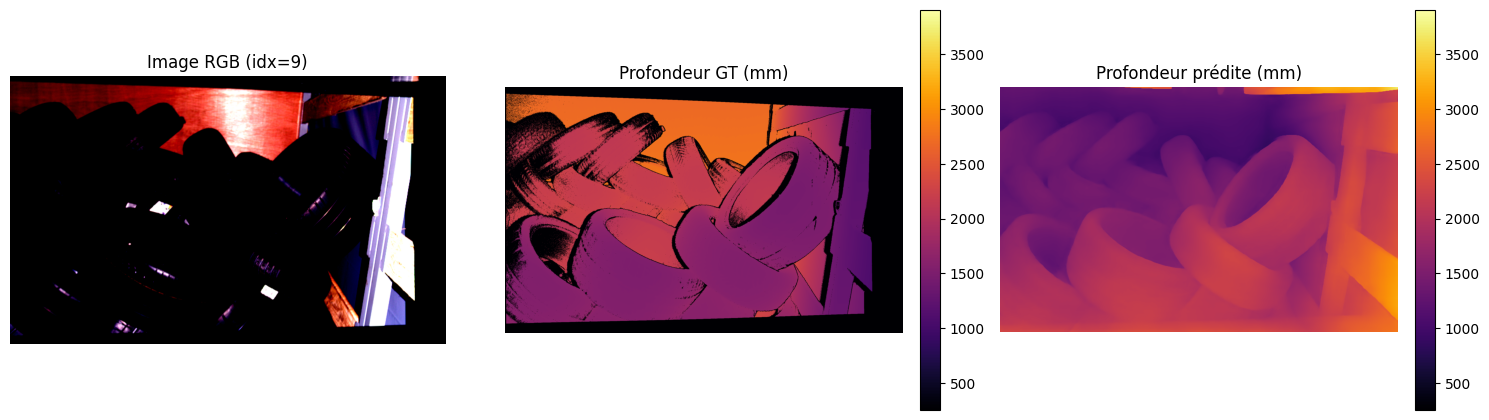

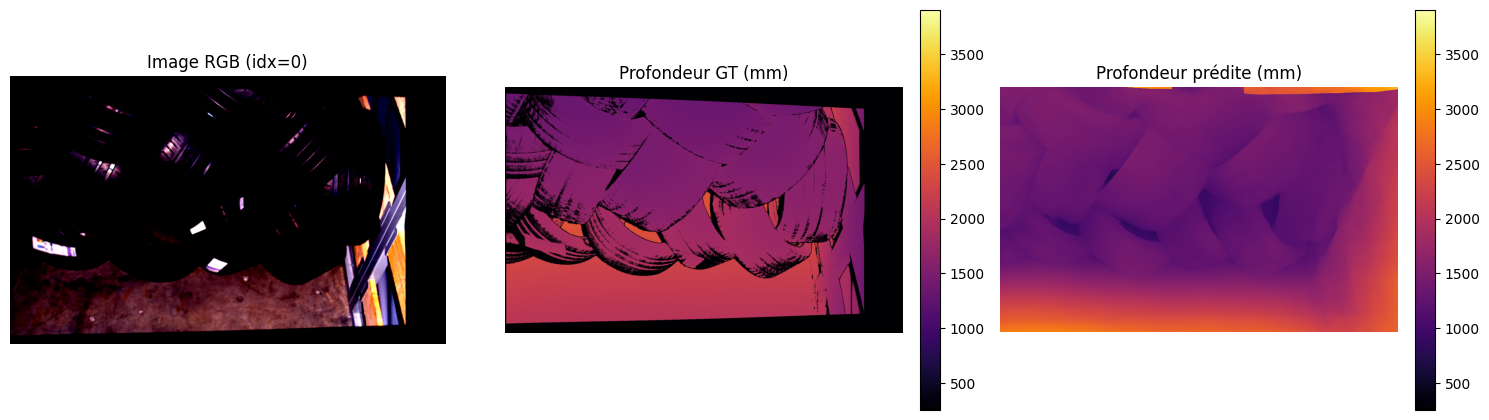

In [40]:
# Voir une image précise
show_sample(0)

# Ou plusieurs images aléatoires
for _ in range(5):
    idx = random.randint(0, len(val_dataset) - 1)
    show_sample(idx)


In [34]:
predictions = trainer.predict(val_dataset)

preds = predictions.predictions   # profondeur prédite (normalisée)
labels = predictions.label_ids    # GT (normalisée)
metrics = predictions.metrics     # si tu as ajouté compute_metrics
print(metrics)


C:\Users\loicd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'test_loss': 0.036418963223695755, 'test_runtime': 10.0563, 'test_samples_per_second': 1.193, 'test_steps_per_second': 0.298}
